In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arch

import copy
import time

# Fama-Macbeth Regression

In [141]:
# Read Data
datalist = pd.read_csv(r"C:\Users\Kran\Desktop\data\ext.csv")

tradingdate = datalist.date.drop_duplicates()
stkid = datalist.permno.drop_duplicates()
daynum = len(tradingdate)
stknum = len(stkid)

datalist = {iter_code: iter_view for iter_code, iter_view in datalist.groupby("permno")}
for iter_key, iter_table in datalist.items():
    datalist[iter_key] = iter_table.set_index("date").reindex(tradingdate)

In [142]:
# Convert Data to Multi-Index Data
datalist = pd.concat(datalist.values(), keys=datalist.keys())
datalist = datalist.drop("permno", axis=1)

In [526]:
# Prepare Regression Data
factorname = list(datalist.columns[1: -1])
regression = ["hsigma", "RET"] + factorname

dataview = datalist.copy()
# Use Factor of Last Day
dataview[factorname] = dataview[factorname].groupby(level=0).shift(1)
# Hsigma Used in Weighting
dataview["hsigma"] = dataview["hsigma"].groupby(level=0).shift(1)
dataview["hsigma"] = dataview.hsigma ** -2

In [527]:
# Generate View for Each Regression
# regview for regression
# fullview for residual
index = pd.Index([i * daynum for i in range(stknum)])
regview = {tradingdate[shift]: dataview.iloc[index + shift].dropna().reset_index(level=1, drop=1) for shift in range(daynum)}
fullview = {tradingdate[shift]: dataview.iloc[index + shift].reset_index(level=1, drop=1) for shift in range(daynum)}

for key in regview.keys():
    # Drop Extreme Return
    regview[key] = regview[key][(regview[key].RET >= regview[key].RET.quantile(0.025)) & (regview[key].RET <= regview[key].RET.quantile(0.975))]
    # Winsorize out 5% quantile, and Standardize in Cross Section
    fullview[key][factorname] = fullview[key][factorname].clip(upper=regview[key][factorname].quantile(0.975), lower=regview[key][factorname].quantile(0.025), axis=1)    
    regview[key][factorname] = regview[key][factorname].clip(upper=regview[key][factorname].quantile(0.975), lower=regview[key][factorname].quantile(0.025), axis=1)    
    fullview[key][factorname] = (fullview[key][factorname] - regview[key][factorname].mean()) / regview[key][factorname].std()
    regview[key][factorname] = (regview[key][factorname] - regview[key][factorname].mean()) / regview[key][factorname].std()
    # Winsorize 1% Hsigma ** -2
    regview[key]["hsigma"] = regview[key].hsigma.clip(upper=regview[key].hsigma.quantile(0.99))
# Regress! With Weight of Hsigma ** -2
regresult = {key: sm.GLS(iter_view.RET, iter_view[factorname], iter_view.hsigma).fit() for key, iter_view in regview.items() if len(iter_view) > len(factorname)}

Factor Return and Selection

In [528]:
# Get Factor Return
# Return is Assumed to be Available at the End of Month
factorreturn = {key: value.params for key, value in regresult.items()}
factorreturn = pd.concat(factorreturn, axis=1).transpose().reindex(tradingdate)

In [529]:
# Factor Return Correlation
factorreturn.corr()

,volatility,momentum,size,size_nl,trading_activity,growth,earning_yield,value,earning_variability,leverage,divyield
volatility,1.000000,-0.148770,0.678413,-0.736013,0.658340,0.035029,-0.609218,-0.132922,0.083958,-0.218463,0.011959
momentum,-0.148770,1.000000,-0.180210,0.259483,-0.332358,0.131922,0.145815,0.117505,-0.005290,0.202384,0.322222
size,0.678413,-0.180210,1.000000,-0.965771,0.518584,-0.011121,-0.433990,-0.026584,0.222871,-0.155624,-0.053804
size_nl,-0.736013,0.259483,-0.965771,1.000000,-0.700601,0.025235,0.557797,0.144772,-0.232674,0.227039,0.099870
trading_activity,0.658340,-0.332358,0.518584,-0.700601,1.000000,0.009280,-0.655652,-0.403269,0.170458,-0.345421,-0.171046
growth,0.035029,0.131922,-0.011121,0.025235,0.009280,1.000000,0.045970,-0.076569,0.242899,0.092739,0.070354
earning_yield,-0.609218,0.145815,-0.433990,0.557797,-0.655652,0.045970,1.000000,0.264062,-0.273216,0.269107,0.097041
value,-0.132922,0.117505,-0.026584,0.144772,-0.403269,-0.076569,0.264062,1.000000,-0.113573,0.357929,0.277652
earning_variability,0.083958,-0.005290,0.222871,-0.232674,0.170458,0.242899,-0.273216,-0.113573,1.000000,0.053654,-0.135775
leverage,-0.218463,0.202384,-0.155624,0.227039,-0.345421,0.092739,0.269107,0.357929,0.053654,1.000000,0.138701


In [530]:
# T Statistics
factorreturn.mean() / factorreturn.std() * np.sqrt(len(factorreturn.dropna()))

volatility            -1.850906
momentum               0.688072
size                   3.397864
size_nl               -2.359890
trading_activity      -0.858549
growth                -0.274354
earning_yield          1.327906
value                  3.602269
earning_variability    3.613787
leverage               0.481261
divyield              -0.313555
dtype: float64

In [531]:
# Sharpe
factorreturn.mean() / factorreturn.std()

volatility            -0.156430
momentum               0.058153
size                   0.287172
size_nl               -0.199447
trading_activity      -0.072561
growth                -0.023187
earning_yield          0.112229
value                  0.304447
earning_variability    0.305421
leverage               0.040674
divyield              -0.026500
dtype: float64

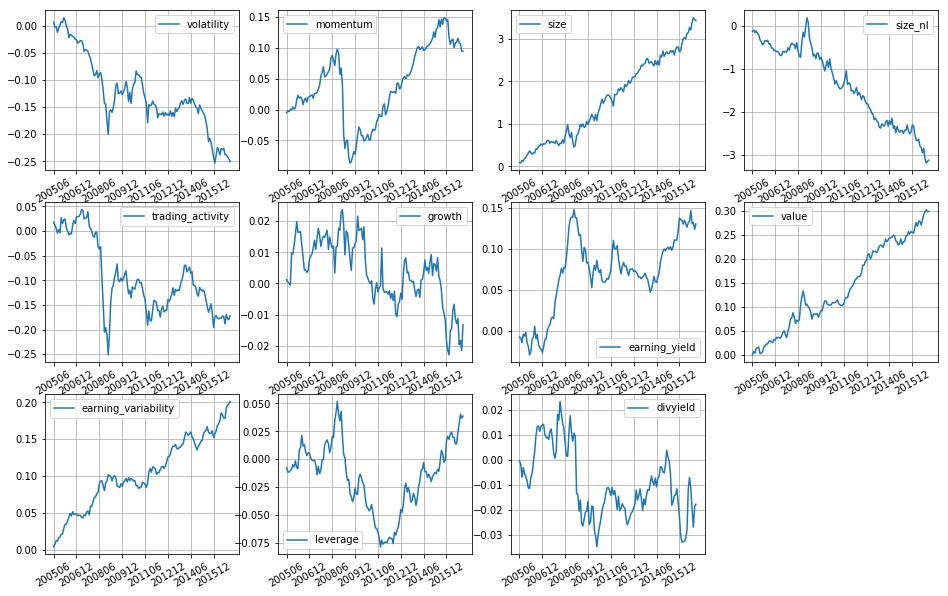

In [534]:
tick = range(0, len(factorreturn), 18)
fig = plt.figure(figsize=(16, 10))
for idx, iter_name in enumerate(factorname):
    ax = fig.add_subplot(3, 4, idx + 1)
    ax.plot(factorreturn.dropna()[iter_name].reset_index(drop=1).cumsum(), label=iter_name)
    plt.xticks(tick, factorreturn.index[tick], rotation=30)
    ax.grid()
    ax.legend()

In [150]:
rsq = pd.Series([iter_res.rsquared for iter_res in regresult.values()])

In [151]:
rsq.mean()

0.14034028720529915

In [152]:
(rsq.mean() - 0.15) / rsq.std() * len(rsq)

-13.244650932009419

# Second Round Fama-Macbeth Regression

In [535]:
# Prepare Regression Data
factorname = ["volatility", "momentum", "size", "earning_yield", "value", "earning_variability", "leverage", "divyield"]
regression = ["hsigma", "RET"] + factorname

dataview = datalist[regression].copy()
# Use Factor of Last Day
dataview[factorname] = dataview[factorname].groupby(level=0).shift(1)
# Hsigma Used in Weighting
dataview["hsigma"] = dataview["hsigma"].groupby(level=0).shift(1)
dataview["hsigma"] = dataview.hsigma ** -2

In [536]:
# Generate View for Each Regression
# regview for regression
# fullview for residual
index = pd.Index([i * daynum for i in range(stknum)])
regview = {tradingdate[shift]: dataview.iloc[index + shift].dropna().reset_index(level=1, drop=1) for shift in range(daynum)}
fullview = {tradingdate[shift]: dataview.iloc[index + shift].reset_index(level=1, drop=1) for shift in range(daynum)}

for key in regview.keys():
    # Drop Extreme Return
    regview[key] = regview[key][(regview[key].RET >= regview[key].RET.quantile(0.025)) & (regview[key].RET <= regview[key].RET.quantile(0.975))]
    # Winsorize out 5% quantile, and Standardize in Cross Section
    fullview[key][factorname] = fullview[key][factorname].clip(upper=regview[key][factorname].quantile(0.975), lower=regview[key][factorname].quantile(0.025), axis=1)    
    regview[key][factorname] = regview[key][factorname].clip(upper=regview[key][factorname].quantile(0.975), lower=regview[key][factorname].quantile(0.025), axis=1)    
    fullview[key][factorname] = (fullview[key][factorname] - regview[key][factorname].mean()) / regview[key][factorname].std()
    regview[key][factorname] = (regview[key][factorname] - regview[key][factorname].mean()) / regview[key][factorname].std()
    # Winsorize 1% Hsigma ** -2
    regview[key]["hsigma"] = regview[key].hsigma.clip(upper=regview[key].hsigma.quantile(0.99))
# Regress! With Weight of Hsigma ** -2
regresult = {key: sm.GLS(iter_view.RET, iter_view[factorname], iter_view.hsigma).fit() for key, iter_view in regview.items() if len(iter_view) > len(factorname)}

Factor Return

In [537]:
# Get Factor Return
# Return is Assumed to be Available at the End of Month
factorreturn = {key: value.params for key, value in regresult.items()}
factorreturn = pd.concat(factorreturn, axis=1).transpose().reindex(tradingdate)

In [538]:
# Factor Return Correlation
factorreturn.corr()

,volatility,momentum,size,earning_yield,value,earning_variability,leverage,divyield
volatility,1.000000,-0.168768,-0.629025,-0.634855,-0.480512,-0.178781,-0.331524,0.009887
momentum,-0.168768,1.000000,0.294530,0.059127,0.142510,0.034034,0.212597,0.327477
size,-0.629025,0.294530,1.000000,0.623758,0.576702,0.078538,0.370214,0.138577
earning_yield,-0.634855,0.059127,0.623758,1.000000,0.432992,0.044518,0.333745,0.000401
value,-0.480512,0.142510,0.576702,0.432992,1.000000,-0.016650,0.437596,0.212922
earning_variability,-0.178781,0.034034,0.078538,0.044518,-0.016650,1.000000,0.168395,-0.069173
leverage,-0.331524,0.212597,0.370214,0.333745,0.437596,0.168395,1.000000,0.156086
divyield,0.009887,0.327477,0.138577,0.000401,0.212922,-0.069173,0.156086,1.000000


In [539]:
# T Statistics
factorreturn.mean() / factorreturn.std() * np.sqrt(len(factorreturn.dropna()))

volatility            -1.633190
momentum               0.667982
size                   2.351359
earning_yield          1.702052
value                  2.585897
earning_variability    3.114156
leverage               0.831083
divyield              -0.154322
dtype: float64

In [540]:
# Sharpe
factorreturn.mean() / factorreturn.std()

volatility            -0.138030
momentum               0.056455
size                   0.198726
earning_yield          0.143850
value                  0.218548
earning_variability    0.263194
leverage               0.070239
divyield              -0.013043
dtype: float64

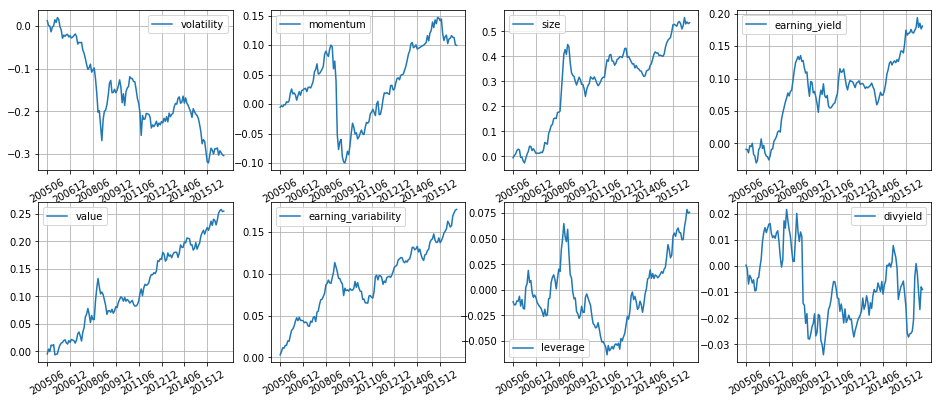

In [541]:
tick = range(0, len(factorreturn), 18)
fig = plt.figure(figsize=(16, 10))
for idx, iter_name in enumerate(factorname):
    ax = fig.add_subplot(3, 4, idx + 1)
    ax.plot(factorreturn.dropna()[iter_name].reset_index(drop=1).cumsum(), label=iter_name)
    plt.xticks(tick, factorreturn.index[tick], rotation=30)
    ax.grid()
    ax.legend()

Covariance Matrix

In [557]:
factorcov = factorreturn.ewm(halflife=90, min_periods=12).cov()
factorcov.index.names = ["date", "factor"]
factorcov = factorcov.dropna()

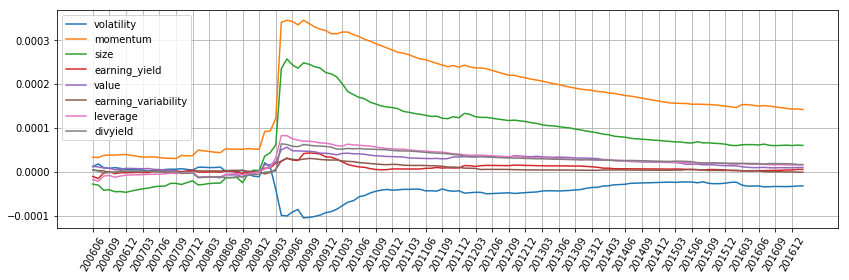

In [562]:
tick = range(0, len(factorcov.index.get_level_values(0).drop_duplicates()), 3)
factorcov.xs("momentum", level="factor").plot(use_index=False, grid=True, figsize=(14, 4))
plt.xticks(tick, factorcov.index.get_level_values(0).drop_duplicates()[tick], rotation=60)
plt.show()

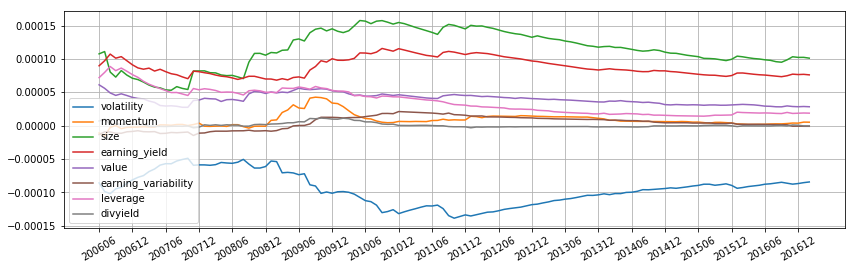

In [563]:
tick = range(0, len(factorcov.index.get_level_values(0).drop_duplicates()), 6)
factorcov.xs("earning_yield", level="factor").plot(use_index=False, grid=True, figsize=(14, 4))
plt.xticks(tick, factorcov.index.get_level_values(0).drop_duplicates()[tick], rotation=30)
plt.show()

Specific Risk

In [564]:
# Generate Residual
residual = [fullview[iter_date].RET - fullview[iter_date][factorname].dot(factorreturn.loc[iter_date].transpose()) for iter_date in tradingdate]
residual = pd.concat(residual, axis=1).transpose()
residual.index = tradingdate

# Specific Risk
residrisk = residual.ewm(halflife=6, min_periods=12).var()

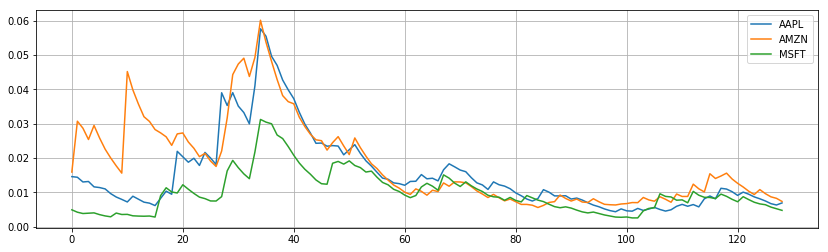

In [587]:
residrisk[14593].dropna().plot(use_index=False, grid=True, figsize=(14, 4), label="AAPL")
residrisk[84788].dropna().plot(use_index=False, grid=True, figsize=(14, 4), label="AMZN")
residrisk[10107].dropna().plot(use_index=False, grid=True, figsize=(14, 4), label="MSFT")
plt.legend()
plt.show()

# Portfolio Construction

In [386]:
loading = pd.concat(fullview)[factorname]

In [533]:
# Data Included in This Part
# loading
# factorreturn
# factorcov
# residrisk

In [509]:
# Portfolio Size
stock_n = 100
testdate = tradingdate[43: -2]
cutoff = 2
maxweight_pos = 0.3
maxweight_neg = -0.3

weight = dict()
expectedreturn = pd.Series(index=testdate)
realreturn = pd.Series(index=testdate)
for iter_pos, iter_date in enumerate(testdate):
    # Prepare Data
    universe = loading.loc[iter_date]
    universe = universe[universe.abs() < cutoff].join(residrisk.loc[iter_date]).dropna()[iter_date].sort_values().index[: stock_n]
    # Data
    _load = loading.loc[iter_date].loc[universe]
    _ret = factorreturn.loc[iter_date]
    _cov = factorcov.loc[iter_date]
    _resid = np.diag(residrisk.loc[iter_date, universe])
    # Optimal Weight
    w = np.linalg.inv(_load.dot(_cov).dot(_load.T) + _resid).dot(_load.dot(_ret))
    w = pd.Series(w / w.sum(), index=universe)
    # Extreme Weight
    w[w > maxweight_pos] = maxweight_pos
    w[w < maxweight_neg] = maxweight_neg
    w = w / w.sum()
    # Expectedreturn
    expectedreturn.loc[iter_date] = w.dot(_load.dot(_ret))
    # For the Next Month
    _select = datalist.RET.iloc[index + iter_pos].loc[universe].dropna()
    w = w.loc[_select.index.get_level_values(0)]
    w = w / w.sum()
    realreturn.loc[iter_date] = (w.values * _select.values).sum()
    # Record Weight
    weight[iter_date] = w.copy()

In [510]:
# Stop Loss
stoploss = -0.1
realreturn[realreturn[realreturn < stoploss].index] = stoploss

In [511]:
# Statistics
statname = ["mean", "std", "Sharpe", "Max", "Min"]
statval = [realreturn.mean() * 12, realreturn.std() * 12 ** 0.5, realreturn.mean() / realreturn.std()  * 12 ** 0.5, realreturn.max(), realreturn.min()]
statval = pd.DataFrame(statval, index=statname, columns=["values"]).transpose()
statval

,mean,std,Sharpe,Max,Min
values,0.070449,0.244142,0.288558,0.383141,-0.1


In [588]:
spx = pd.read_csv(r"C:\Users\Kran\Desktop\data\sp500.csv", index_col="date")
spx.index = (spx.index / 100).astype(int)

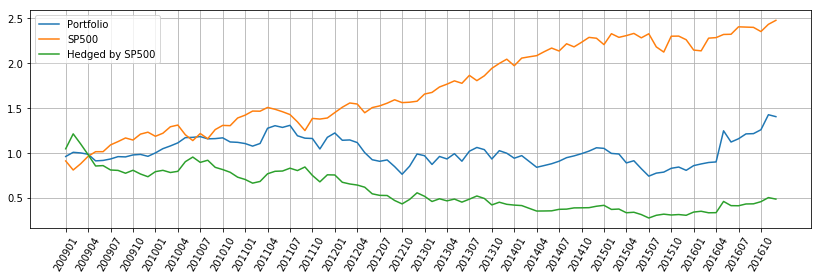

In [512]:
# Graph Setting
int_month = 3
tick = range(0, len(realreturn), int_month)

# Equity Plot
(realreturn + 1).cumprod().plot(use_index=False, grid=True, figsize=(14, 4), label="Portfolio")
plt.plot(range(0, len(realreturn)), (spx.sprtrn.loc[testdate] + 1).cumprod(), label="SP500")
plt.plot((realreturn - spx.sprtrn.loc[testdate] + 1).cumprod().reset_index(drop=1), label="Hedged by SP500")
plt.xticks(tick, realreturn.index[tick], rotation=60)
plt.legend()
plt.show()

# Risk Analysis

In [513]:
sysrisk = pd.Series(index=testdate)
idorisk = pd.Series(index=testdate)

In [514]:
for iter_pos, iter_date in enumerate(testdate):
    _portweight = weight[iter_date].values
    _portidx = weight[iter_date].index
    _portloading = loading.loc[iter_date].loc[_portidx]
    _cov = _portloading.dot(factorcov.loc[iter_date]).dot(_portloading.T)
    _portresid = np.diag(residrisk.loc[iter_date].loc[_portidx])
    
    sysrisk.loc[iter_date] = _portweight.dot(_cov).dot(_portweight)
    idorisk.loc[iter_date] = _portweight.dot(_portresid).dot(_portweight)

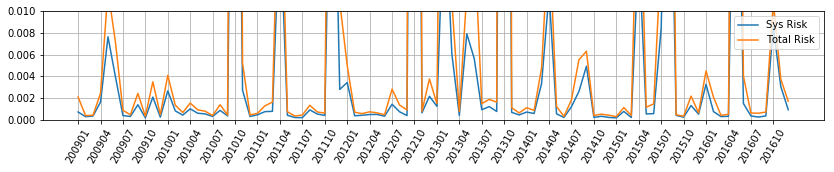

In [515]:
sysrisk.plot(use_index=False, grid=True, figsize=(14, 2), label="Sys Risk")
plt.ylim(0, 0.01)
plt.plot((sysrisk + idorisk).reset_index(drop=1), label="Total Risk")
plt.xticks(tick, realreturn.index[tick], rotation=60)
plt.legend()
plt.show()

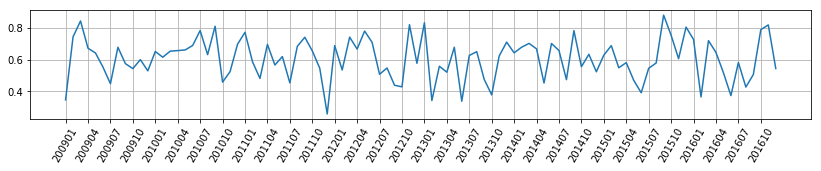

In [516]:
(sysrisk / (sysrisk + idorisk)).plot(use_index=False, grid=True, figsize=(14, 2))
plt.xticks(tick, realreturn.index[tick], rotation=60)
plt.show()